In [ ]:
# -*- coding: utf-8 -*-
"""YOLOv8-12m Tested on T4"""

# Check GPU (should show NVIDIA Tesla T4)
!nvidia-smi

Thu Jun 12 15:58:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Install Ultralytics
!pip install ultralytics --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.8 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Confirm saved model weights
!ls /content/drive/MyDrive/1_YOLO_Benchmark_Results_2025

Detections		      YOLO_A100_Benchmark_2025.gsheet
learning_accuracy_graph.png   YOLOv10m_a100_results.txt
UpdatedMetrices		      YOLOv10m_best.pt
YOLO11m_a100_results.txt      YOLOv8m_a100_results.txt
YOLO11m_best.pt		      YOLOv8m_best.pt
YOLO12m_a100_results.txt      YOLOv9m_a100_results.txt
YOLO12m_best.pt		      YOLOv9m_best.pt
YOLO_A100_Benchmark_2025.csv


In [ ]:
# Confirm dataset structure
!ls /content/drive/MyDrive/YOLODataset

annotations  data.yaml	test  train  val  yolo8m


In [ ]:
!cat /content/drive/MyDrive/YOLODataset/data.yaml

train: /content/drive/MyDrive/YOLODataset/train/images
val: /content/drive/MyDrive/YOLODataset/val/images
test: /content/drive/MyDrive/YOLODataset/test/images

nc: 2
names: ["hat", "person"]


In [ ]:
# Import libraries
from ultralytics import YOLO
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Set paths
DATASET_PATH = '/content/drive/MyDrive/YOLODataset/data.yaml'
SAVE_DIR = '/content/drive/MyDrive/1_YOLO_Benchmark_Results_T4/UpdatedMetrices'
!mkdir -p $SAVE_DIR

# Define models and their saved weights
models = {
    'YOLOv8m': '/content/drive/MyDrive/1_YOLO_Benchmark_Results_2025/YOLOv8m_best.pt',
    'YOLOv9m': '/content/drive/MyDrive/1_YOLO_Benchmark_Results_2025/YOLOv9m_best.pt',
    'YOLOv10m': '/content/drive/MyDrive/1_YOLO_Benchmark_Results_2025/YOLOv10m_best.pt',
    'YOLOv11m': '/content/drive/MyDrive/1_YOLO_Benchmark_Results_2025/YOLO11m_best.pt',
    'YOLOv12m': '/content/drive/MyDrive/1_YOLO_Benchmark_Results_2025/YOLO12m_best.pt'
}

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Initialize results table
results_table = []

# Test each model
for model_name, model_weights in models.items():
    print(f"\nTesting {model_name} on T4 GPU...\n")
    try:
        # Load pre-trained model
        model = YOLO(model_weights)

        # Get model size in MB
        model_size = os.path.getsize(model_weights) / (1024 * 1024)  # Convert to MB
        model_size = round(model_size, 2)

        start_time = time.time()

        # Validate on test set
        metrics = model.val(
            data=DATASET_PATH,
            split='test',
            imgsz=640,
            batch=16,
            device=0,  # T4 GPU
            name=f'{model_name}_test_t4'
        )

        end_time = time.time()
        duration = round((end_time - start_time) / 60, 2)  # Validation time in minutes

        # Extract metrics from results_dict
        precision = round(metrics.results_dict['metrics/precision(B)'], 4)
        recall = round(metrics.results_dict['metrics/recall(B)'], 4)
        map50 = round(metrics.results_dict['metrics/mAP50(B)'], 4)
        map50_95 = round(metrics.results_dict['metrics/mAP50-95(B)'], 4)

        # Handle speed metrics safely
        speed_inference = metrics.speed.get('inference', 0)
        fps = round(1000 / speed_inference, 2) if speed_inference > 0 else 0

        # Save result to .txt
        with open(f"{SAVE_DIR}/{model_name}_t4_results.txt", "w") as f:
            f.write(f"Model: {model_name} (T4 GPU)\n")
            f.write(f"Precision: {precision}\n")
            f.write(f"Recall: {recall}\n")
            f.write(f"mAP@50: {map50}\n")
            f.write(f"mAP@50-95: {map50_95}\n")
            f.write(f"Inference Speed: {speed_inference:.2f} ms per image (~{fps} FPS)\n")
            f.write(f"Validation Time: {duration} minutes\n")
            f.write(f"Model Size: {model_size} MB\n")

        # Append to results table
        results_table.append([model_name, precision, recall, map50, map50_95, fps, duration, model_size])

    except Exception as e:
        print(f"Error with {model_name}: {e}")
        continue

# Save results to CSV
df = pd.DataFrame(results_table, columns=["Model", "Precision", "Recall", "mAP@50", "mAP@50-95", "FPS", "Validation Time (min)", "Model Size (MB)"])
df.to_csv(f"{SAVE_DIR}/YOLO_T4_Benchmark_Comparison.csv", index=False)
print("\nT4 Testing Completed! Results saved to YOLO_T4_Benchmark_Comparison.csv")

# Display results
print(df)


Testing YOLOv8m on T4 GPU...

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 24.3MB/s]


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.5±0.7 MB/s, size: 359.0 KB)


val: Scanning /content/drive/MyDrive/YOLODataset/test/labels.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:53<00:00,  1.34it/s]


                   all       1138      17977      0.923      0.881      0.936      0.603
                   hat        486       1611      0.918      0.844      0.919      0.685
                person        721      16366      0.928      0.919      0.953       0.52
Speed: 0.2ms preprocess, 14.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/YOLOv8m_test_t4

Testing YOLOv9m on T4 GPU...

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9m summary (fused): 151 layers, 20,014,438 parameters, 0 gradients, 76.5 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 20.6±13.9 MB/s, size: 49.6 KB)


val: Scanning /content/drive/MyDrive/YOLODataset/test/labels.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:27<00:00,  2.66it/s]


                   all       1138      17977      0.921      0.883      0.936      0.606
                   hat        486       1611       0.91      0.853      0.917      0.689
                person        721      16366      0.933      0.912      0.956      0.524
Speed: 0.3ms preprocess, 16.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/YOLOv9m_test_t4

Testing YOLOv10m on T4 GPU...

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,314,326 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 31.7±20.9 MB/s, size: 39.7 KB)


val: Scanning /content/drive/MyDrive/YOLODataset/test/labels.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:24<00:00,  2.93it/s]


                   all       1138      17977      0.919      0.874      0.934      0.604
                   hat        486       1611      0.916      0.844      0.916      0.687
                person        721      16366      0.922      0.904      0.951      0.521
Speed: 0.4ms preprocess, 13.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/YOLOv10m_test_t4

Testing YOLOv11m on T4 GPU...

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 77.7±73.4 MB/s, size: 165.4 KB)


val: Scanning /content/drive/MyDrive/YOLODataset/test/labels.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:33<00:00,  2.18it/s]


                   all       1138      17977      0.907      0.893      0.938      0.611
                   hat        486       1611      0.881      0.871      0.921      0.697
                person        721      16366      0.933      0.916      0.956      0.525
Speed: 0.3ms preprocess, 16.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/YOLOv11m_test_t4

Testing YOLOv12m on T4 GPU...

Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,106,454 parameters, 0 gradients, 67.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 29.2±17.4 MB/s, size: 52.5 KB)


val: Scanning /content/drive/MyDrive/YOLODataset/test/labels.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:30<00:00,  2.32it/s]


                   all       1138      17977      0.905      0.889      0.936      0.604
                   hat        486       1611      0.887      0.858      0.918      0.687
                person        721      16366      0.923       0.92      0.954      0.522
Speed: 0.2ms preprocess, 20.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/YOLOv12m_test_t4

T4 Testing Completed! Results saved to YOLO_T4_Benchmark_Comparison.csv
      Model  Precision  Recall  mAP@50  mAP@50-95    FPS  \
0   YOLOv8m     0.9231  0.8815  0.9359     0.6029  71.60   
1   YOLOv9m     0.9213  0.8828  0.9363     0.6062  59.49   
2  YOLOv10m     0.9191  0.8740  0.9338     0.6038  71.96   
3  YOLOv11m     0.9069  0.8932  0.9385     0.6110  60.92   
4  YOLOv12m     0.9051  0.8889  0.9361     0.6044  50.10   

   Validation Time (min)  Model Size (MB)  
0                   1.28            49.60  
1                   0.52            38.92  
2                   0.48            31


Generating Precision Bar Charts



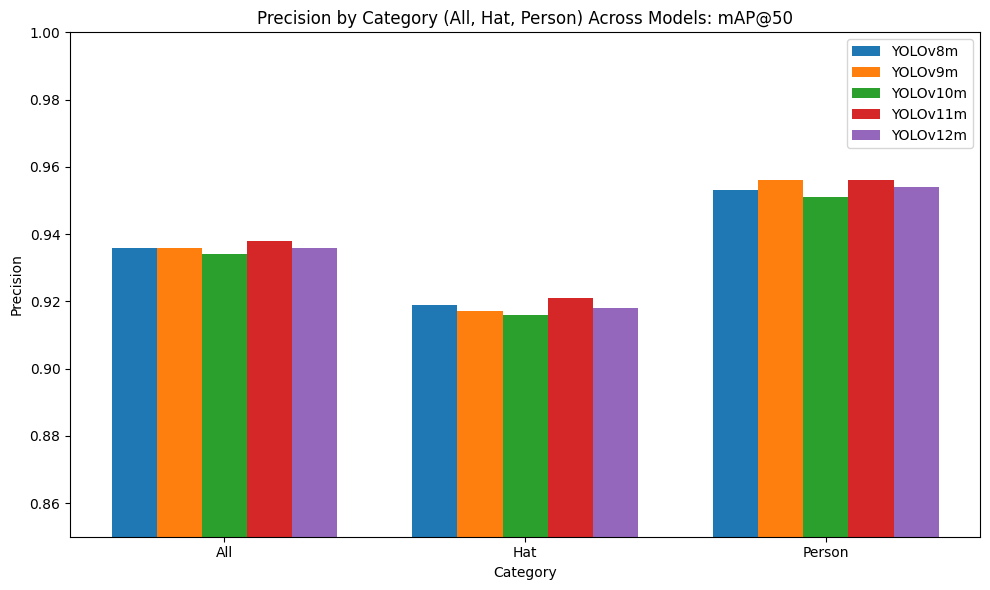

Chart saved to /content/drive/MyDrive/1_YOLO_Benchmark_Results_T4/UpdatedMetrices/precision_by_category.png


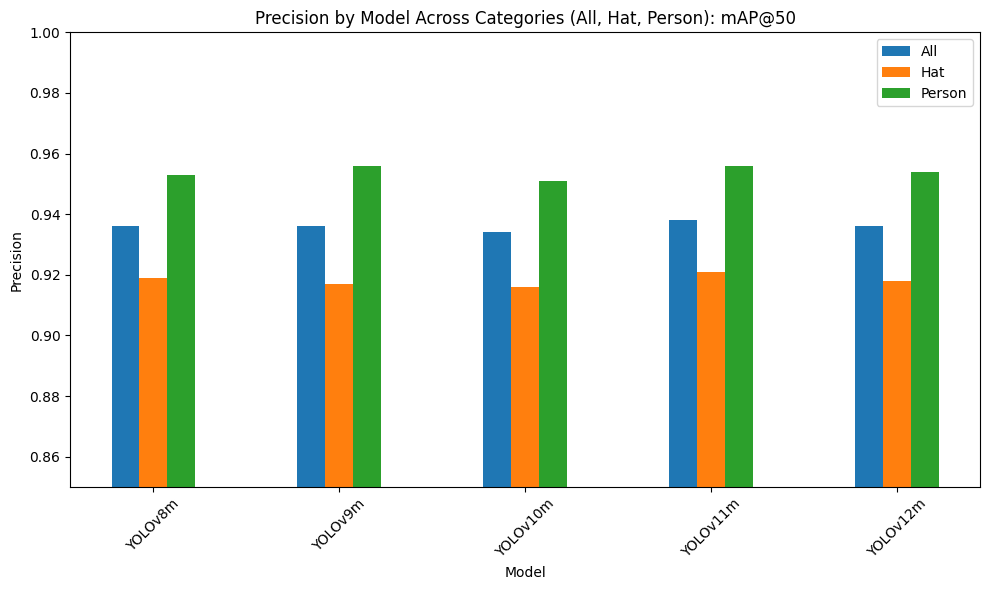

Chart saved to /content/drive/MyDrive/1_YOLO_Benchmark_Results_T4/UpdatedMetrices/precision_by_model.png


In [ ]:
# Generate Precision Bar Charts
print("\nGenerating Precision Bar Charts\n")

SAVE_DIR = '/content/drive/MyDrive/1_YOLO_Benchmark_Results_T4/UpdatedMetrices'

# Define precision data from T4 validation output (hardcoded as in original)
precision_data = {
    'YOLOv8m': {'all': 0.936, 'hat': 0.919, 'person': 0.953},
    'YOLOv9m': {'all': 0.936, 'hat': 0.917, 'person': 0.956},
    'YOLOv10m': {'all': 0.934, 'hat': 0.916, 'person': 0.951},
    'YOLOv11m': {'all': 0.938, 'hat': 0.921, 'person': 0.956},
    'YOLOv12m': {'all': 0.936, 'hat': 0.918, 'person': 0.954}
}

# Chart 1: Precision by Category (All, Hat, Person) Across Models
fig, ax = plt.subplots(figsize=(10, 6))
models = list(precision_data.keys())
categories = ['all', 'hat', 'person']
bar_width = 0.15
x = np.arange(len(categories))

for i, model in enumerate(models):
    precisions = [precision_data[model][cat] for cat in categories]
    ax.bar(x + i * bar_width, precisions, bar_width, label=model)

ax.set_xlabel('Category')
ax.set_ylabel('Precision')
ax.set_title('Precision by Category (All, Hat, Person) Across Models: mAP@50')
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels([cat.capitalize() for cat in categories])
ax.set_ylim(0.85, 1.0)
ax.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/precision_by_category.png", dpi=100, bbox_inches='tight')
plt.show()
print(f"Chart saved to {SAVE_DIR}/precision_by_category.png")

# Chart 2: Precision by Model Across Categories (All, Hat, Person)
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))

for i, category in enumerate(categories):
    precisions = [precision_data[model][category] for model in models]
    ax.bar(x + i * bar_width, precisions, bar_width, label=category.capitalize())

ax.set_xlabel('Model')
ax.set_ylabel('Precision')
ax.set_title('Precision by Model Across Categories (All, Hat, Person): mAP@50')
ax.set_xticks(x + bar_width * (len(categories) - 1) / 2)
ax.set_xticklabels(models, rotation=45)
ax.set_ylim(0.85, 1.0)
ax.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/precision_by_model.png", dpi=100, bbox_inches='tight')
plt.show()
print(f"Chart saved to {SAVE_DIR}/precision_by_model.png")



Generating mAP@50-95 Bar Charts



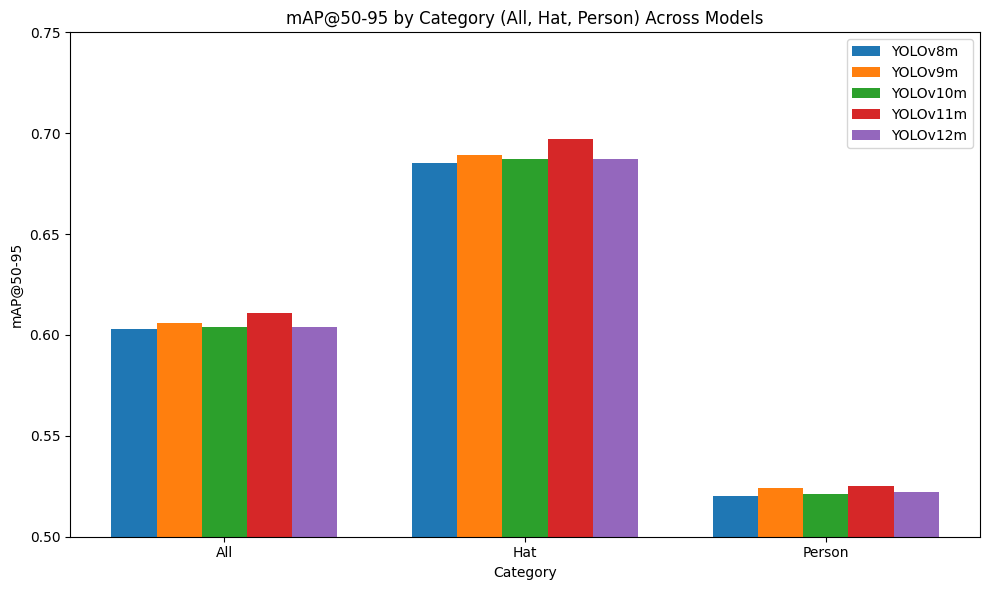

Chart saved to /content/drive/MyDrive/1_YOLO_Benchmark_Results_T4/UpdatedMetrices/map50_95_by_category.png


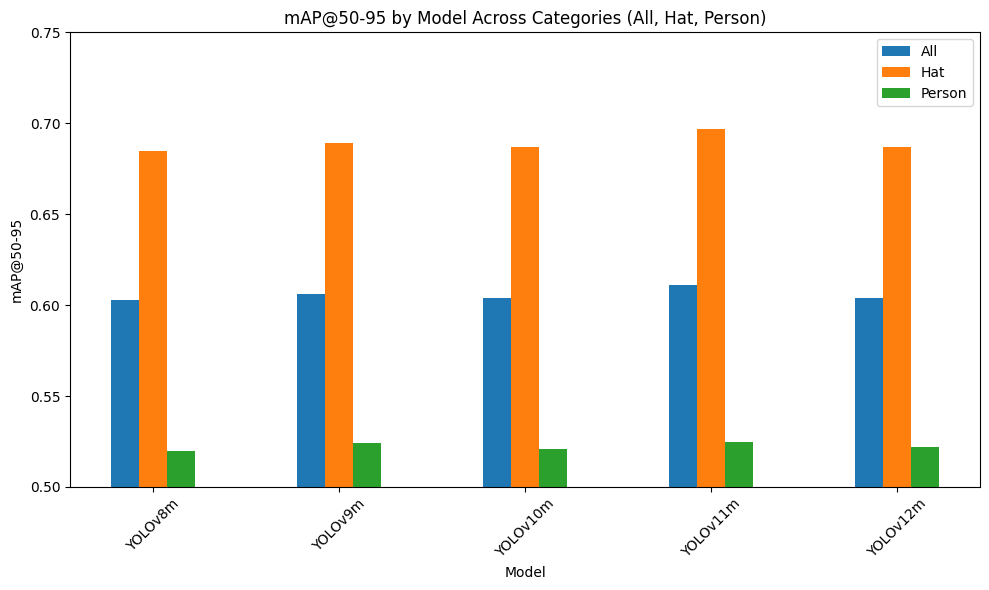

Chart saved to /content/drive/MyDrive/1_YOLO_Benchmark_Results_T4/UpdatedMetrices/map50_95_by_model.png


In [ ]:
# Generate mAP@50-95 Bar Charts
print("\nGenerating mAP@50-95 Bar Charts\n")

# Define mAP@50-95 data from T4 validation output (hardcoded as in original)
map50_95_data = {
    'YOLOv8m': {'all': 0.603, 'hat': 0.685, 'person': 0.52},
    'YOLOv9m': {'all': 0.606, 'hat': 0.689, 'person': 0.524},
    'YOLOv10m': {'all': 0.604, 'hat': 0.687, 'person': 0.521},
    'YOLOv11m': {'all': 0.611, 'hat': 0.697, 'person': 0.525},
    'YOLOv12m': {'all': 0.604, 'hat': 0.687, 'person': 0.522}
}

# Chart 1: mAP@50-95 by Category (All, Hat, Person) Across Models
fig, ax = plt.subplots(figsize=(10, 6))
models = list(map50_95_data.keys())
categories = ['all', 'hat', 'person']
bar_width = 0.15
x = np.arange(len(categories))

for i, model in enumerate(models):
    values = [map50_95_data[model][cat] for cat in categories]
    ax.bar(x + i * bar_width, values, bar_width, label=model)

ax.set_xlabel('Category')
ax.set_ylabel('mAP@50-95')
ax.set_title('mAP@50-95 by Category (All, Hat, Person) Across Models')
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels([cat.capitalize() for cat in categories])
ax.set_ylim(0.5, 0.75)
ax.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/map50_95_by_category.png", dpi=100, bbox_inches='tight')
plt.show()
print(f"Chart saved to {SAVE_DIR}/map50_95_by_category.png")

# Chart 2: mAP@50-95 by Model Across Categories (All, Hat, Person)
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))

for i, category in enumerate(categories):
    values = [map50_95_data[model][category] for model in models]
    ax.bar(x + i * bar_width, values, bar_width, label=category.capitalize())

ax.set_xlabel('Model')
ax.set_ylabel('mAP@50-95')
ax.set_title('mAP@50-95 by Model Across Categories (All, Hat, Person)')
ax.set_xticks(x + bar_width * (len(categories) - 1) / 2)
ax.set_xticklabels(models, rotation=45)
ax.set_ylim(0.5, 0.75)
ax.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/map50_95_by_model.png", dpi=100, bbox_inches='tight')
plt.show()
print(f"Chart saved to {SAVE_DIR}/map50_95_by_model.png")



Generating Balance Chart (mAP@50-95 vs FPS)



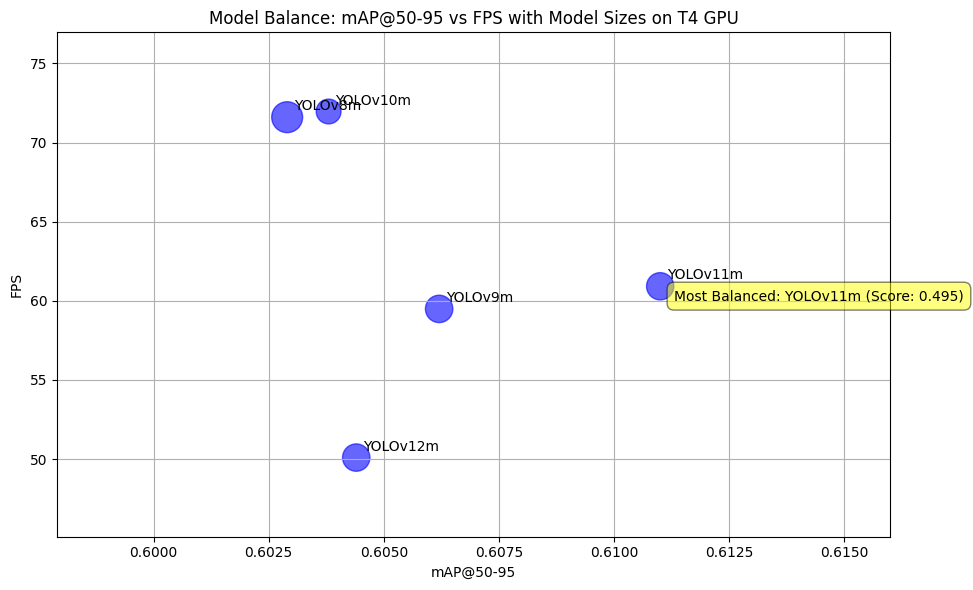

Chart saved to /content/drive/MyDrive/1_YOLO_Benchmark_Results_T4/UpdatedMetrices/balance_map50_95_vs_fps.png


In [ ]:
# Generate Balance Chart: mAP@50-95 vs FPS
print("\nGenerating Balance Chart (mAP@50-95 vs FPS)\n")

# Use DataFrame data instead of hardcoded values
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df['mAP@50-95'], df['FPS'], s=df['Model Size (MB)'] * 10, c='blue', alpha=0.6)

# Annotate each point with model name
for i, model in enumerate(df['Model']):
    ax.annotate(model, (df['mAP@50-95'][i], df['FPS'][i]), xytext=(5, 5), textcoords='offset points')

# Labels and title
ax.set_xlabel('mAP@50-95')
ax.set_ylabel('FPS')
ax.set_title('Model Balance: mAP@50-95 vs FPS with Model Sizes on T4 GPU')
ax.grid(True)

# Calculate and display balance score
map50_95_min, map50_95_max = df['mAP@50-95'].min(), df['mAP@50-95'].max()
fps_min, fps_max = df['FPS'].min(), df['FPS'].max()
normalized_map50_95 = (df['mAP@50-95'] - map50_95_min) / (map50_95_max - map50_95_min)
normalized_fps = (df['FPS'] - fps_min) / (fps_max - fps_min)
balance_scores = normalized_map50_95 * normalized_fps
max_balance_idx = balance_scores.idxmax()
max_balance_model = df['Model'][max_balance_idx]
max_balance_score = balance_scores[max_balance_idx]

ax.annotate(f'Most Balanced: {max_balance_model} (Score: {max_balance_score:.3f})',
            xy=(df['mAP@50-95'][max_balance_idx], df['FPS'][max_balance_idx]),
            xytext=(10, -10), textcoords='offset points', bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5))

# Adjust limits to fit annotations
ax.set_xlim(map50_95_min - 0.005, map50_95_max + 0.005)
ax.set_ylim(fps_min - 5, fps_max + 5)

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/balance_map50_95_vs_fps.png", dpi=100, bbox_inches='tight')
plt.show()
print(f"Chart saved to {SAVE_DIR}/balance_map50_95_vs_fps.png")